In [1]:
import sys
sys.path.append('C:\\projects\\UTNCE\\src\\utnce')

In [2]:
from simplify import *
from prepare import *
from routing import *
from percolation_plot import *
from generate import *
from transfer import *
from copy import deepcopy
from shapely.geometry import Point
from pyproj import Proj, Transformer

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

# Subway-Amsterdam  metro51

## Generate subway networks

In [4]:
# Secondly, creates a dictionary that maps start station names to their corresponding destinations
def start_station_dict(routes_file):
    """
    Creates a dictionary mapping start station names to their corresponding destinations.

    Args:
        routes_file (pandas.DataFrame): A DataFrame containing route information.

    Returns:
        dict: A dictionary mapping start station names to their destinations.
    """
    # Initialize an empty dictionary to store the mappings
    start_station_name_dict = {} 

    # Iterate over each row in the DataFrame
    for index, row in routes_file.iterrows():  
        # Get the start station name from the 'name' column
        key = row['name'] 
        # Get the destination from the 'to' column
        value = row['to']  
        # Add the mapping to the dictionary
        start_station_name_dict[key] = value  
    # Return the dictionary    
    return start_station_name_dict

    
# Creates a dictionary mapping line names to their corresponding indices
def line_dict(routes_file):
    """
    Creates a dictionary mapping line names to their corresponding indices.

    Args:
        routes_file (pandas.DataFrame): A DataFrame containing route information.

    Returns:
        dict: A dictionary mapping line names to their corresponding indices.
    """
    # Initialize an empty dictionary to store line names and indices
    line_num_dict = {}  

    # Iterate over each row in the routes_file DataFrame
    for index, row in routes_file.iterrows():
        # Get the value in the 'name' column of the current row
        key = row['name']  
        # Add an entry to the dictionary with the line name as the key and the index as the value
        line_num_dict[key] = index  
    
    # Return the line_num_dict dictionary as the output
    return line_num_dict  


# Create a list for all_station with selected columns
def all_station_list(all_stations_file):
    """
    Extracts relevant information from a GeoDataFrame containing station data.

    Args:
        all_stations_file (GeoDataFrame): A GeoDataFrame containing station information.

    Returns:
        GeoDataFrame: A GeoDataFrame with selected columns ('name', 'geometry', 'geo_x', 'geo_y').

    """
    # Create a copy of the all_stations_file as a GeoDataFrame
    all_stations_file = gpd.GeoDataFrame(all_stations_file.copy())
    
    # Select specific columns ('name', 'geometry', 'geo_x', 'geo_y') and reset the index
    all_stations_name = all_stations_file[['name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
    
    # Return the resulting GeoDataFrame with selected columns
    return all_stations_name

# # Sorting the stations on each route
# def order_route(first_stop, unordered_route):
#     new_order = []
#     remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index).reset_index(drop=True)
#     tree = shapely.STRtree(remaining_route.geometry)
#     new_order.append(first_stop)
#     for iter_ in range(len(remaining_route)):
#         try:
#             if iter_ == 0:
#                 nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
#                 new_order.append(nearest_station)
#                 remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)
#                 tree = shapely.STRtree(remaining_route.geometry)
#             elif iter_ == 1:
#                 second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
#                 new_order.append(second_station)
#                 remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
#                 tree = shapely.STRtree(remaining_route.geometry)
#             else:
#                 second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
#                 new_order.append(second_station)
#                 remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
#                 tree = shapely.STRtree(remaining_route.geometry)
#         except TypeError:
#             pass  # pass 'NoneType' object is not subscriptable Error
#     return pd.concat(new_order).reset_index(drop=True)
    
# Sorting the stations on each route
def order_route(first_stop, unordered_route):
    """
    Orders the route based on the nearest stations.

    Args:
        first_stop (pandas.Series): The first stop to start the route(Destination actually).
        unordered_route (pandas.DataFrame): The unordered route containing stops.

    Returns:
        pandas.DataFrame: The ordered route based on the nearest stations.
    """
    new_order = []

    # Remove the first stop from the unordered route
    remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index).reset_index(drop=True)

    # Build an STRtree index for the remaining route
    tree = shapely.strtree.STRtree(remaining_route.geometry)

    # Append the first stop to the new order
    new_order.append(first_stop)

    for iter_ in range(len(remaining_route)):
        try:
            if iter_ == 0:
                # Find the nearest station to the first stop
                nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
                new_order.append(nearest_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.strtree.STRtree(remaining_route.geometry)
            elif iter_ == 1:
                # Find the second nearest station to the first stop
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.strtree.STRtree(remaining_route.geometry)
            else:
                # Find the next nearest station based on the previous station
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.strtree.STRtree(remaining_route.geometry)
        except TypeError:
            pass  # Ignore 'NoneType' object is not subscriptable error

    # Concatenate the ordered stops into a DataFrame
    ordered_route = pd.concat(new_order).reset_index(drop=True)
    # Reverse the sequence to 
    ordered_route = ordered_route.iloc[::-1].reset_index(drop=True)
    return ordered_route


# Orders stations based on the tram line routes and start station names
def order_stations_inline(tram_line_dict, all_tram_stations_name, tram_routes, tram_start_station_name_dict):
    """
    Orders the tram stations based on the tram line routes and start station names.

    Args:
        tram_line_dict (dict): A dictionary containing tram line information.
        all_tram_stations_name (DataFrame): A DataFrame containing all tram station names.
        tram_routes (DataFrame): A DataFrame containing tram route information.
        tram_start_station_name_dict (dict): A dictionary mapping tram line names to their respective start station names.

    Returns:
        dict: A dictionary containing ordered tram station routes for each tram line.
    """
    
    # Create a copy of the tram_line_dict dictionary
    tram_stations_dict = tram_line_dict.copy()

    # Iterate over each key-value pair in tram_stations_dict
    for key, value in tram_stations_dict.items():
        value1 = value
        # Filter the all_tram_stations_name DataFrame to include only stations within the buffer of the corresponding tram route
        value2 = all_tram_stations_name.loc[all_tram_stations_name.within(tram_routes.iloc[value1].geometry.buffer(0.000001))]
        # Assign new IDs to the filtered stations
        value2['id'] = value2.reset_index().index
        # Update the value in tram_stations_dict to include only necessary columns and reset the index
        tram_stations_dict[key] = value2[['id', 'name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)

    # Create copies of tram_line_dict for storing tram stations in order and ordered routes
    tram_stations_inorder_dict = tram_line_dict.copy()
    tram_order_route_dict = tram_line_dict.copy()

    # Iterate over each line in tram_stations_inorder_dict
    for line in tram_stations_inorder_dict.keys():
        tram_stations_inorder = tram_stations_dict[line]
        # Find the start station for the current line and update tram_stations_inorder_dict with only that station
        for i in range(len(tram_stations_inorder)):
            if tram_stations_inorder.iloc[i]['name'] == tram_start_station_name_dict[line]:
                tram_stations_inorder_dict[line] = pd.DataFrame(tram_stations_inorder.iloc[i]).T
        # Call the order_route function to order the remaining stations and store the result in tram_order_route_dict
        tram_order_route_dict[line] = order_route(tram_stations_inorder_dict[line], tram_stations_dict[line])

    return tram_order_route_dict

In [5]:
# Subway/Metro
def prepare_metro(osm_path):
    """
    Prepares the metro network data based on the given OSM path.

    Args:
        osm_path (str): The path to the OpenStreetMap (OSM) file.

    Returns:
        tuple: A tuple containing the following metro network data:
            - city_sub_stations: Sub-stations in the city
            - edges: Edges (connections) between stations in the network
            - nodes: Nodes (stations) in the network
            - city_sub_routes: Sub-routes in the city
            - check_name: Result of the check operation
    """

    # Obtain sub-stations in the city
    city_sub_stations = sub_stations(osm_path)

    # Obtain subway network data
    city_sub_network = subway_network(osm_path)

    # Prepare the network edges and nodes based on sub-stations and subway network
    edges, nodes = prepare_network(city_sub_network, city_sub_stations)

    # Expand the edges if required
    edges = expand_edges(edges)

    # Retrieve sub-stations again (optional, as it was already obtained before)
    city_sub_stations = sub_stations(osm_path)

    # Obtain sub-routes in the city
    city_sub_routes = sub_routes(osm_path)

    # Sort the sub-routes
    city_sub_routes = sorted_routes(city_sub_routes)

    # Check the name and assign a column
    check_name = check_to_column(city_sub_routes, city_sub_stations)

    # Return all the obtained data
    return city_sub_stations, edges, nodes, city_sub_routes, check_name

def recheck_metro_routes(replacement_dict, city_sub_stations, city_sub_routes):
    """
    This function rechecks the metro routes based on the given inputs.

    Args:
    - city_sub_stations: Dataframe or data structure containing subway station information for the city.
    - replacement_dict: A dictionary used to replace certain values in the 'to' column of metro routes.
    - city_sub_routes: Dataframe or data structure containing metro route information for the city.

    Returns:
    - check_name: A list of boolean values indicating whether the 'to' column in the metro routes matches the station names.
    - city_sub_routes: a dataframe of routes after changing the start staion name according to city_sub_stations.
    """

    # Replace values in the 'to' column of the metro routes using the replacement dictionary
    city_sub_routes['to'] = city_sub_routes['to'].replace(replacement_dict, regex=True).str.strip()

    # Reset the index of the metro routes
    city_sub_routes = city_sub_routes.reset_index(drop=True)

    # Check if the values in the 'to' column of the metro routes match the station names
    check_name = check_to_column(city_sub_routes, city_sub_stations)

    return city_sub_routes, check_name

def metro(city_sub_stations, edges, nodes, city_sub_routes, city='Rotterdam'):
    """
    Performs various operations on the metro network data to calculate shortest paths and plot routes.

    Args:
        city_sub_stations (list): List of sub-stations in the city.
        edges (list): List of edges (connections) between stations in the network.
        nodes (list): List of nodes (stations) in the network.
        city_sub_routes (list): List of sub-routes in the city.
        city (str, optional): Name of the city. Defaults to 'Rotterdam'.

    Returns:
        tuple: A tuple containing the following calculated data:
            - city_sub_shortest_path_pairs: Shortest path pairs for each subway line.
            - city_sub_shortest_path_edges: Shortest path edges for each subway line.
            - city_sub_edges: Subway network edges for each subway line.
    """

    # Create a dictionary mapping start stations to their corresponding routes
    city_sub_start_station_name_dict = start_station_dict(city_sub_routes)

    # Create a dictionary mapping subway lines to their corresponding routes
    city_sub_line_dict = line_dict(city_sub_routes)

    # Create a list of all station names in the city's subway network
    city_all_sub_stations_name = all_station_list(city_sub_stations)

    # Create a dictionary mapping subway lines to the ordered list of stations on each line
    city_sub_order_route_dict = order_stations_inline(city_sub_line_dict, city_all_sub_stations_name, city_sub_routes, city_sub_start_station_name_dict)

    # Create a dictionary mapping subway lines to the pairs of station IDs on each line
    city_sub_order_id_pairs = id_pairs_inline(city_sub_line_dict, city_sub_order_route_dict, nodes)

    # Create a graph representing the subway network using the extracted edges and nodes
    G = create_ground_graph(edges, nodes)

    # Calculate the shortest path pairs for each subway line
    city_sub_shortest_path_pairs = city_sub_order_id_pairs.copy()
    duplicate_row_count = city_sub_order_id_pairs.copy()
    city_sub_shortest_path_edges = city_sub_order_id_pairs.copy()
    city_sub_edges = city_sub_order_id_pairs.copy()

    for line in city_sub_order_id_pairs.keys():
        # Calculate all shortest paths for the current line using the subway network edges
        city_sub_shortest_path_pairs[line] = all_shortest_paths(G, city_sub_order_id_pairs[line], edges)

        # Count the duplicate rows, calculate the weighted edges for shortest paths,
        # and update the subway network edges for the current line
        duplicate_row_count[line], city_sub_shortest_path_edges[line], city_sub_edges[line] = edges_with_count_weight(city_sub_shortest_path_pairs[line], edges)
        sub_edges = city_sub_edges[line]
    
    # # Plot the subway routes with even indices
    # plot_routes_even(city_sub_routes, edges, city_sub_shortest_path_edges)

    # # Plot the subway routes with odd indices
    # plot_routes_odd(city_sub_routes, edges, city_sub_shortest_path_edges)
        
    # Plot all subway routes
    plot_routes(city_sub_routes, edges, city_sub_shortest_path_edges)

    # Return the calculated data
    return city_sub_order_route_dict, city_sub_shortest_path_pairs, city_sub_shortest_path_edges, sub_edges #city_sub_edges

In [6]:
sub_stations, edges, nodes, sub_routes, check_name = prepare_metro(osm_path)

topology: 100%|████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 4544.74it/s]


In [7]:
sub_stations

,osm_id,public_transport,railway,tram,subway,highway,bus,name,geometry,geo_x,geo_y
129,240489038,stop_position,stop,None,yes,None,None,Wibautstraat,POINT (4.91205 52.35459),4.912049,52.354595
134,250222259,stop_position,stop,None,yes,None,None,Zuid,POINT (4.87398 52.33904),4.873978,52.339035
136,250222332,stop_position,stop,None,yes,None,None,Station Sloterdijk,POINT (4.83898 52.38904),4.838979,52.389038
137,250222348,stop_position,stop,None,yes,None,None,Isolatorweg,POINT (4.85060 52.39510),4.850596,52.395103
138,250224115,stop_position,stop,None,yes,None,None,De Vlugtlaan,POINT (4.83806 52.37946),4.838056,52.379461
...,...,...,...,...,...,...,...,...,...,...,...
3469,7106870068,stop_position,stop,None,yes,None,None,Waterlooplein,POINT (4.90361 52.36664),4.903606,52.366636
3470,7106870071,stop_position,stop,None,yes,None,None,Waterlooplein,POINT (4.90375 52.36669),4.903753,52.366690
3471,7106870124,stop_position,stop,None,yes,None,None,Nieuwmarkt,POINT (4.90094 52.37142),4.900938,52.371424
3472,7106910981,stop_position,stop,None,yes,None,None,Weesperplein,POINT (4.90792 52.36133),4.907918,52.361326


In [8]:
# sub_stations[sub_stations.name == 'Wibautstraat']

In [9]:
# sub_stations = sub_stations.drop_duplicates(subset='geometry')
# sub_stations

In [10]:
# sub_stations[sub_stations.name == 'Wibautstraat']

In [11]:
replacement_dict = {
     'Amsterdam Centraal': 'Centraal Station',
}


sub_routes, check_name = recheck_metro_routes(replacement_dict, sub_stations, sub_routes)

In [12]:
sub_routes

,osm_id,route,to,name,ref,network,service,geometry
0,18683,subway,Isolatorweg,Metro 50: Gein => Isolatorweg,50,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."
1,4515354,subway,Gein,Metro 50: Isolatorweg => Gein,50,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83880 52.38842, 4.83897 52..."
2,31249,subway,Isolatorweg,Metro 51: Centraal Station => Isolatorweg,51,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90193 52.37689, 4.90202 52..."
3,4515355,subway,Centraal Station,Metro 51: Isolatorweg => Centraal Station,51,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83880 52.38842, 4.83897 52..."
4,8466667,subway,Zuid,Metro 52: Noord => Zuid,52,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.93265 52.40228, 4.93269 52..."
5,8466671,subway,Noord,Metro 52: Zuid => Noord,52,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87423 52.33922, 4.87552 52..."
6,18532,subway,Gaasperplas,Metro 53: Centraal Station => Gaasperplas,53,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90193 52.37689, 4.90202 52..."
7,4515356,subway,Centraal Station,Metro 53: Gaasperplas => Centraal Station,53,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98373 52.31201, 4.98364 52..."
8,18423,subway,Gein,Metro 54: Centraal Station => Gein,54,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90193 52.37689, 4.90202 52..."
9,4515357,subway,Centraal Station,Metro 54: Gein => Centraal Station,54,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."


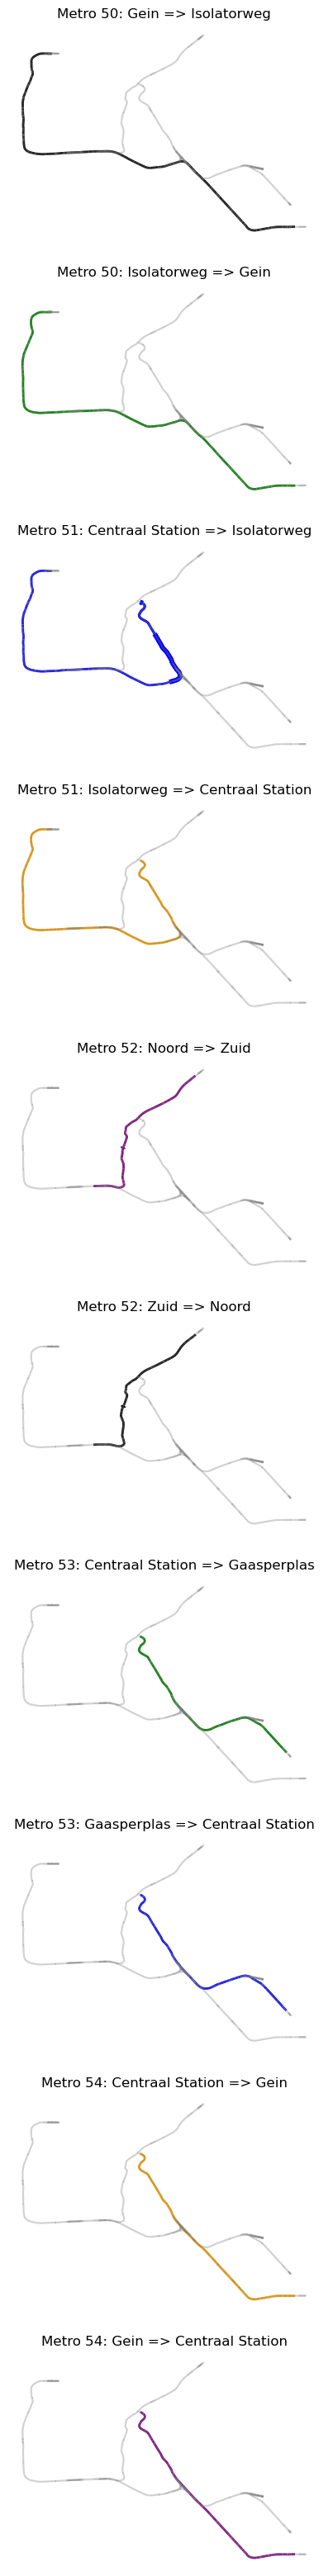

In [13]:
sub_order_route_dict, sub_shortest_path_pairs, sub_shortest_path_edges, sub_edges = metro(sub_stations, edges, nodes, sub_routes, city='Amsterdam')

In [14]:
city_sub_start_station_name_dict = start_station_dict(sub_routes)
city_sub_start_station_name_dict

{'Metro 50: Gein => Isolatorweg': 'Isolatorweg',
 'Metro 50: Isolatorweg => Gein': 'Gein',
 'Metro 51: Centraal Station => Isolatorweg': 'Isolatorweg',
 'Metro 51: Isolatorweg => Centraal Station': 'Centraal Station',
 'Metro 52: Noord => Zuid': 'Zuid',
 'Metro 52: Zuid => Noord': 'Noord',
 'Metro 53: Centraal Station => Gaasperplas': 'Gaasperplas',
 'Metro 53: Gaasperplas => Centraal Station': 'Centraal Station',
 'Metro 54: Centraal Station => Gein': 'Gein',
 'Metro 54: Gein => Centraal Station': 'Centraal Station'}

In [15]:
city_sub_line_dict = line_dict(sub_routes)
city_sub_line_dict

{'Metro 50: Gein => Isolatorweg': 0,
 'Metro 50: Isolatorweg => Gein': 1,
 'Metro 51: Centraal Station => Isolatorweg': 2,
 'Metro 51: Isolatorweg => Centraal Station': 3,
 'Metro 52: Noord => Zuid': 4,
 'Metro 52: Zuid => Noord': 5,
 'Metro 53: Centraal Station => Gaasperplas': 6,
 'Metro 53: Gaasperplas => Centraal Station': 7,
 'Metro 54: Centraal Station => Gein': 8,
 'Metro 54: Gein => Centraal Station': 9}

In [16]:
def all_station_list(all_stations_file):
    """
    Extracts relevant information from a GeoDataFrame containing station data.

    Args:
        all_stations_file (GeoDataFrame): A GeoDataFrame containing station information.

    Returns:
        GeoDataFrame: A GeoDataFrame with selected columns ('name', 'geometry', 'geo_x', 'geo_y').

    """
    # Create a copy of the all_stations_file as a GeoDataFrame
    all_stations_file = gpd.GeoDataFrame(all_stations_file.copy())
    
    # Select specific columns ('name', 'geometry', 'geo_x', 'geo_y') and reset the index
    # all_stations_name = all_stations_file[['name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
    all_stations_name = all_stations_file[['name', 'geometry', 'geo_x', 'geo_y']]
    
    # Return the resulting GeoDataFrame with selected columns
    return all_stations_name

In [17]:
city_all_sub_stations_name = all_station_list(sub_stations)
city_all_sub_stations_name

,name,geometry,geo_x,geo_y
129,Wibautstraat,POINT (4.91205 52.35459),4.912049,52.354595
134,Zuid,POINT (4.87398 52.33904),4.873978,52.339035
136,Station Sloterdijk,POINT (4.83898 52.38904),4.838979,52.389038
137,Isolatorweg,POINT (4.85060 52.39510),4.850596,52.395103
138,De Vlugtlaan,POINT (4.83806 52.37946),4.838056,52.379461
...,...,...,...,...
3469,Waterlooplein,POINT (4.90361 52.36664),4.903606,52.366636
3470,Waterlooplein,POINT (4.90375 52.36669),4.903753,52.366690
3471,Nieuwmarkt,POINT (4.90094 52.37142),4.900938,52.371424
3472,Weesperplein,POINT (4.90792 52.36133),4.907918,52.361326


In [18]:
city_all_sub_stations_name[city_all_sub_stations_name.name == 'Wibautstraat']

,name,geometry,geo_x,geo_y
129,Wibautstraat,POINT (4.91205 52.35459),4.912049,52.354595
1103,Wibautstraat,POINT (4.91190 52.35456),4.911895,52.354560


In [19]:
city_all_sub_stations_name.to_excel('.\city_all_sub_stations_name.xlsx',header = True, index = False)

In [20]:
def order_route(first_stop, unordered_route):
    """
    Orders the route based on the nearest stations.

    Args:
        first_stop (pandas.Series): The first stop to start the route(Destination actually).
        unordered_route (pandas.DataFrame): The unordered route containing stops.

    Returns:
        pandas.DataFrame: The ordered route based on the nearest stations.
    """
    new_order = []

    # Remove the first stop from the unordered route
    remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index)#.reset_index(drop=True)

    # Build an STRtree index for the remaining route
    tree = shapely.strtree.STRtree(remaining_route.geometry)

    # Append the first stop to the new order
    new_order.append(first_stop)

    for iter_ in range(len(remaining_route)):
        try:
            if iter_ == 0:
                # Find the nearest station to the first stop
                nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
                new_order.append(nearest_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index)#.reset_index(drop=True)
                tree = shapely.strtree.STRtree(remaining_route.geometry)
            elif iter_ == 1:
                # Find the second nearest station to the first stop
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index)#.reset_index(drop=True)
                tree = shapely.strtree.STRtree(remaining_route.geometry)
            else:
                # Find the next nearest station based on the previous station
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index)#.reset_index(drop=True)
                tree = shapely.strtree.STRtree(remaining_route.geometry)
        except TypeError:
            pass  # Ignore 'NoneType' object is not subscriptable error

    # Concatenate the ordered stops into a DataFrame
    ordered_route = pd.concat(new_order)#.reset_index(drop=True)
    # # Reverse the sequence to 
    # ordered_route = ordered_route.iloc[::-1].reset_index(drop=True)
    return ordered_route


# Orders stations based on the tram line routes and start station names
def order_stations_inline(tram_line_dict, all_tram_stations_name, tram_routes, tram_start_station_name_dict):
    """
    Orders the tram stations based on the tram line routes and start station names.

    Args:
        tram_line_dict (dict): A dictionary containing tram line information.
        all_tram_stations_name (DataFrame): A DataFrame containing all tram station names.
        tram_routes (DataFrame): A DataFrame containing tram route information.
        tram_start_station_name_dict (dict): A dictionary mapping tram line names to their respective start station names.

    Returns:
        dict: A dictionary containing ordered tram station routes for each tram line.
    """
    
    # Create a copy of the tram_line_dict dictionary
    tram_stations_dict = tram_line_dict.copy()

    # Iterate over each key-value pair in tram_stations_dict
    for key, value in tram_stations_dict.items():
        value1 = value
        # Filter the all_tram_stations_name DataFrame to include only stations within the buffer of the corresponding tram route
        value2 = all_tram_stations_name.loc[all_tram_stations_name.within(tram_routes.iloc[value1].geometry.buffer(0.000001))]
        # Assign new IDs to the filtered stations
        # value2['id'] = value2.reset_index().index
        # Update the value in tram_stations_dict to include only necessary columns and reset the index
        # tram_stations_dict[key] = value2[['id', 'name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
        tram_stations_dict[key] = value2[['name', 'geometry', 'geo_x', 'geo_y']]

    # Create copies of tram_line_dict for storing tram stations in order and ordered routes
    tram_stations_inorder_dict = tram_line_dict.copy()
    tram_order_route_dict = tram_line_dict.copy()

    # Iterate over each line in tram_stations_inorder_dict
    for line in tram_stations_inorder_dict.keys():
        tram_stations_inorder = tram_stations_dict[line]
        # Find the start station for the current line and update tram_stations_inorder_dict with only that station
        for i in range(len(tram_stations_inorder)):
            if tram_stations_inorder.iloc[i]['name'] == tram_start_station_name_dict[line]:
                tram_stations_inorder_dict[line] = pd.DataFrame(tram_stations_inorder.iloc[i]).T
        # Call the order_route function to order the remaining stations and store the result in tram_order_route_dict
        tram_order_route_dict[line] = order_route(tram_stations_inorder_dict[line], tram_stations_dict[line])

    return tram_order_route_dict,tram_stations_dict

In [21]:
# Create a copy of the tram_line_dict dictionary
city_sub_stations_dict = city_sub_line_dict.copy()

# Iterate over each key-value pair in tram_stations_dict
for key, value in city_sub_stations_dict.items():
    value1 = value
    # Filter the all_tram_stations_name DataFrame to include only stations within the buffer of the corresponding tram route
    value2 = city_all_sub_stations_name.loc[city_all_sub_stations_name.within(sub_routes.iloc[value1].geometry.buffer(0.000001))]
    # Assign new IDs to the filtered stations
    # value2['id'] = value2.reset_index().index
    print(value2)
    # Update the value in tram_stations_dict to include only necessary columns and reset the index
    # city_sub_stations_dict[key] = value2[['id', 'name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
    city_sub_stations_dict[key] = value2[['name', 'geometry', 'geo_x', 'geo_y']]

# Create copies of tram_line_dict for storing tram stations in order and ordered routes
city_sub_stations_inorder_dict = city_sub_line_dict.copy()
city_sub_order_route_dict = city_sub_line_dict.copy()

city_sub_stations_inorder = city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg']
    # Find the start station for the current line and update tram_stations_inorder_dict with only that station
for i in range(len(city_sub_stations_inorder)):
    if city_sub_stations_inorder.iloc[i]['name'] == city_sub_start_station_name_dict['Metro 51: Centraal Station => Isolatorweg']:
        city_sub_stations_inorder_dict['Metro 51: Centraal Station => Isolatorweg'] = pd.DataFrame(city_sub_stations_inorder.iloc[i]).T
    # Call the order_route function to order the remaining stations and store the result in tram_order_route_dict
city_sub_order_route_dict['Metro 51: Centraal Station => Isolatorweg'] = order_route(city_sub_stations_inorder_dict['Metro 51: Centraal Station => Isolatorweg'], city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg'])

                     name                  geometry     geo_x      geo_y
136    Station Sloterdijk  POINT (4.83898 52.38904)  4.838979  52.389038
137           Isolatorweg  POINT (4.85060 52.39510)  4.850596  52.395103
141       Heemstedestraat  POINT (4.83440 52.35233)  4.834401  52.352329
144           Strandvliet  POINT (4.94140 52.31861)  4.941398  52.318612
145         Bijlmer ArenA  POINT (4.94762 52.31181)  4.947618  52.311806
148                  Gein  POINT (4.98916 52.29641)  4.989161  52.296407
149             Bullewijk  POINT (4.95213 52.30687)  4.952129  52.306869
1863      Van der Madeweg  POINT (4.93045 52.32978)  4.930454  52.329785
1878      Amstelveenseweg  POINT (4.85757 52.33848)  4.857571  52.338475
1881           Overamstel  POINT (4.91761 52.33177)  4.917606  52.331769
1884                 Zuid  POINT (4.87396 52.33932)  4.873963  52.339322
1886    Henk Sneevlietweg  POINT (4.83457 52.34639)  4.834574  52.346387
1890             Lelylaan  POINT (4.83447 52.35806)

In [22]:
sub_routes

,osm_id,route,to,name,ref,network,service,geometry
0,18683,subway,Isolatorweg,Metro 50: Gein => Isolatorweg,50,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."
1,4515354,subway,Gein,Metro 50: Isolatorweg => Gein,50,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83880 52.38842, 4.83897 52..."
2,31249,subway,Isolatorweg,Metro 51: Centraal Station => Isolatorweg,51,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90193 52.37689, 4.90202 52..."
3,4515355,subway,Centraal Station,Metro 51: Isolatorweg => Centraal Station,51,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83880 52.38842, 4.83897 52..."
4,8466667,subway,Zuid,Metro 52: Noord => Zuid,52,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.93265 52.40228, 4.93269 52..."
5,8466671,subway,Noord,Metro 52: Zuid => Noord,52,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87423 52.33922, 4.87552 52..."
6,18532,subway,Gaasperplas,Metro 53: Centraal Station => Gaasperplas,53,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90193 52.37689, 4.90202 52..."
7,4515356,subway,Centraal Station,Metro 53: Gaasperplas => Centraal Station,53,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98373 52.31201, 4.98364 52..."
8,18423,subway,Gein,Metro 54: Centraal Station => Gein,54,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90193 52.37689, 4.90202 52..."
9,4515357,subway,Centraal Station,Metro 54: Gein => Centraal Station,54,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."


In [23]:
city_sub_stations_dict

{'Metro 50: Gein => Isolatorweg':                      name                  geometry     geo_x      geo_y
 136    Station Sloterdijk  POINT (4.83898 52.38904)  4.838979  52.389038
 137           Isolatorweg  POINT (4.85060 52.39510)  4.850596  52.395103
 141       Heemstedestraat  POINT (4.83440 52.35233)  4.834401  52.352329
 144           Strandvliet  POINT (4.94140 52.31861)  4.941398  52.318612
 145         Bijlmer ArenA  POINT (4.94762 52.31181)  4.947618  52.311806
 148                  Gein  POINT (4.98916 52.29641)  4.989161  52.296407
 149             Bullewijk  POINT (4.95213 52.30687)  4.952129  52.306869
 1863      Van der Madeweg  POINT (4.93045 52.32978)  4.930454  52.329785
 1878      Amstelveenseweg  POINT (4.85757 52.33848)  4.857571  52.338475
 1881           Overamstel  POINT (4.91761 52.33177)  4.917606  52.331769
 1884                 Zuid  POINT (4.87396 52.33932)  4.873963  52.339322
 1886    Henk Sneevlietweg  POINT (4.83457 52.34639)  4.834574  52.346387
 1890

In [24]:
city_sub_stations_inorder_dict

{'Metro 50: Gein => Isolatorweg': 0,
 'Metro 50: Isolatorweg => Gein': 1,
 'Metro 51: Centraal Station => Isolatorweg':             name                      geometry     geo_x      geo_y
 137  Isolatorweg  POINT (4.8505958 52.3951031)  4.850596  52.395103,
 'Metro 51: Isolatorweg => Centraal Station': 3,
 'Metro 52: Noord => Zuid': 4,
 'Metro 52: Zuid => Noord': 5,
 'Metro 53: Centraal Station => Gaasperplas': 6,
 'Metro 53: Gaasperplas => Centraal Station': 7,
 'Metro 54: Centraal Station => Gein': 8,
 'Metro 54: Gein => Centraal Station': 9}

In [25]:
city_sub_start_station_name_dict['Metro 51: Centraal Station => Isolatorweg']

'Isolatorweg'

In [26]:
city_sub_stations_inorder_dict

{'Metro 50: Gein => Isolatorweg': 0,
 'Metro 50: Isolatorweg => Gein': 1,
 'Metro 51: Centraal Station => Isolatorweg':             name                      geometry     geo_x      geo_y
 137  Isolatorweg  POINT (4.8505958 52.3951031)  4.850596  52.395103,
 'Metro 51: Isolatorweg => Centraal Station': 3,
 'Metro 52: Noord => Zuid': 4,
 'Metro 52: Zuid => Noord': 5,
 'Metro 53: Centraal Station => Gaasperplas': 6,
 'Metro 53: Gaasperplas => Centraal Station': 7,
 'Metro 54: Centraal Station => Gein': 8,
 'Metro 54: Gein => Centraal Station': 9}

In [27]:
city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg']

,name,geometry,geo_x,geo_y
136,Station Sloterdijk,POINT (4.83898 52.38904),4.838979,52.389038
137,Isolatorweg,POINT (4.85060 52.39510),4.850596,52.395103
141,Heemstedestraat,POINT (4.83440 52.35233),4.834401,52.352329
1103,Wibautstraat,POINT (4.91190 52.35456),4.911895,52.354560
1467,Centraal Station,POINT (4.90087 52.37735),4.900869,52.377355
1837,Amstelstation,POINT (4.91741 52.34664),4.917406,52.346636
1870,Spaklerweg,POINT (4.92080 52.34023),4.920800,52.340235
1878,Amstelveenseweg,POINT (4.85757 52.33848),4.857571,52.338475
1880,Overamstel,POINT (4.91767 52.33169),4.917668,52.331694
1884,Zuid,POINT (4.87396 52.33932),4.873963,52.339322


In [40]:
city_sub_stations_dict['Metro 51: Isolatorweg => Centraal Station']

,name,geometry,geo_x,geo_y
129,Wibautstraat,POINT (4.91205 52.35459),4.912049,52.354595
134,Zuid,POINT (4.87398 52.33904),4.873978,52.339035
138,De Vlugtlaan,POINT (4.83806 52.37946),4.838056,52.379461
140,Postjesweg,POINT (4.83386 52.36460),4.833861,52.364599
142,Henk Sneevlietweg,POINT (4.83439 52.34638),4.834395,52.346385
143,Centraal Station,POINT (4.90105 52.37751),4.901047,52.377508
222,Heemstedestraat,POINT (4.83423 52.35233),4.834225,52.352325
1838,Amstelstation,POINT (4.91748 52.34665),4.917477,52.346648
1871,Spaklerweg,POINT (4.92085 52.34025),4.920853,52.340246
1877,Amstelveenseweg,POINT (4.85759 52.33834),4.857592,52.338339


In [38]:
city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg'].iloc[3] = city_sub_stations_dict['Metro 51: Isolatorweg => Centraal Station'].iloc[0]

In [39]:
city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg']

,name,geometry,geo_x,geo_y
136,Station Sloterdijk,POINT (4.83898 52.38904),4.838979,52.389038
137,Isolatorweg,POINT (4.85060 52.39510),4.850596,52.395103
141,Heemstedestraat,POINT (4.83440 52.35233),4.834401,52.352329
1103,Wibautstraat,POINT (4.91205 52.35459),4.912049,52.354595
1467,Centraal Station,POINT (4.90087 52.37735),4.900869,52.377355
1837,Amstelstation,POINT (4.91741 52.34664),4.917406,52.346636
1870,Spaklerweg,POINT (4.92080 52.34023),4.920800,52.340235
1878,Amstelveenseweg,POINT (4.85757 52.33848),4.857571,52.338475
1880,Overamstel,POINT (4.91767 52.33169),4.917668,52.331694
1884,Zuid,POINT (4.87396 52.33932),4.873963,52.339322


In [46]:
new_order = []

#Remove the first stop from the unordered route
remaining_route = city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg'].drop(city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg'][city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg'].name == city_sub_stations_inorder_dict['Metro 51: Centraal Station => Isolatorweg'].name.values[0]].index)#.reset_index(drop=True)

# Build an STRtree index for the remaining route
tree = shapely.strtree.STRtree(remaining_route.geometry)

# Append the first stop to the new order
new_order.append(city_sub_stations_inorder_dict['Metro 51: Centraal Station => Isolatorweg'])


In [47]:
print(new_order)

[            name                      geometry     geo_x      geo_y
137  Isolatorweg  POINT (4.8505958 52.3951031)  4.850596  52.395103]


In [48]:
for iter_ in range(len(remaining_route)):
    try:
        if iter_ == 0:
            # Find the nearest station to the first stop
            nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(city_sub_stations_inorder_dict['Metro 51: Centraal Station => Isolatorweg'].geometry)[0]]).T
            new_order.append(nearest_station)
            remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index)#.reset_index(drop=True)
            tree = shapely.strtree.STRtree(remaining_route.geometry)
            print(nearest_station)
        elif iter_ == 1:
            # Find the second nearest station to the first stop
            second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
            new_order.append(second_station)
            remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index)#.reset_index(drop=True)
            tree = shapely.strtree.STRtree(remaining_route.geometry)
            print(second_station)
        else:
            # Find the next nearest station based on the previous station
            second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
            new_order.append(second_station)
            remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index)#.reset_index(drop=True)
            tree = shapely.strtree.STRtree(remaining_route.geometry)
            print(second_station)
        # if iter_== 9:
        #     break
    except TypeError:
        pass  # Ignore 'NoneType' object is not subscriptable error

# Concatenate the ordered stops into a DataFrame
ordered_route = pd.concat(new_order)#.reset_index(drop=True)

                   name                      geometry     geo_x      geo_y
136  Station Sloterdijk  POINT (4.8389786 52.3890375)  4.838979  52.389038
              name                     geometry     geo_x      geo_y
1891  De Vlugtlaan  POINT (4.838233 52.3794484)  4.838233  52.379448
                     name                      geometry     geo_x      geo_y
1894  Jan van Galenstraat  POINT (4.8353639 52.3725816)  4.835364  52.372582
            name                      geometry     geo_x      geo_y
1897  Postjesweg  POINT (4.8340343 52.3645962)  4.834034  52.364596
          name                      geometry     geo_x      geo_y
1890  Lelylaan  POINT (4.8344667 52.3580615)  4.834467  52.358061
                name                     geometry     geo_x      geo_y
141  Heemstedestraat  POINT (4.834401 52.3523291)  4.834401  52.352329
                   name                      geometry     geo_x      geo_y
1886  Henk Sneevlietweg  POINT (4.8345741 52.3463868)  4.834574  52.34638

In [45]:
row_to_delete = 1103
city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg'] = city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg'].drop(row_to_delete)
city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg']

,name,geometry,geo_x,geo_y
136,Station Sloterdijk,POINT (4.83898 52.38904),4.838979,52.389038
137,Isolatorweg,POINT (4.85060 52.39510),4.850596,52.395103
141,Heemstedestraat,POINT (4.83440 52.35233),4.834401,52.352329
1467,Centraal Station,POINT (4.90087 52.37735),4.900869,52.377355
1837,Amstelstation,POINT (4.91741 52.34664),4.917406,52.346636
1870,Spaklerweg,POINT (4.92080 52.34023),4.920800,52.340235
1878,Amstelveenseweg,POINT (4.85757 52.33848),4.857571,52.338475
1880,Overamstel,POINT (4.91767 52.33169),4.917668,52.331694
1884,Zuid,POINT (4.87396 52.33932),4.873963,52.339322
1886,Henk Sneevlietweg,POINT (4.83457 52.34639),4.834574,52.346387


In [46]:
new_order = []

#Remove the first stop from the unordered route
remaining_route = city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg'].drop(city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg'][city_sub_stations_dict['Metro 51: Centraal Station => Isolatorweg'].name == city_sub_stations_inorder_dict['Metro 51: Centraal Station => Isolatorweg'].name.values[0]].index)#.reset_index(drop=True)

# Build an STRtree index for the remaining route
tree = shapely.strtree.STRtree(remaining_route.geometry)

# Append the first stop to the new order
new_order.append(city_sub_stations_inorder_dict['Metro 51: Centraal Station => Isolatorweg'])


In [47]:
print(new_order)

[            name                      geometry     geo_x      geo_y
137  Isolatorweg  POINT (4.8505958 52.3951031)  4.850596  52.395103]


In [48]:
for iter_ in range(len(remaining_route)):
    try:
        if iter_ == 0:
            # Find the nearest station to the first stop
            nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(city_sub_stations_inorder_dict['Metro 51: Centraal Station => Isolatorweg'].geometry)[0]]).T
            new_order.append(nearest_station)
            remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index)#.reset_index(drop=True)
            tree = shapely.strtree.STRtree(remaining_route.geometry)
            print(nearest_station)
        elif iter_ == 1:
            # Find the second nearest station to the first stop
            second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
            new_order.append(second_station)
            remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index)#.reset_index(drop=True)
            tree = shapely.strtree.STRtree(remaining_route.geometry)
            print(second_station)
        else:
            # Find the next nearest station based on the previous station
            second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
            new_order.append(second_station)
            remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index)#.reset_index(drop=True)
            tree = shapely.strtree.STRtree(remaining_route.geometry)
            print(second_station)
        # if iter_== 9:
        #     break
    except TypeError:
        pass  # Ignore 'NoneType' object is not subscriptable error

# Concatenate the ordered stops into a DataFrame
ordered_route = pd.concat(new_order)#.reset_index(drop=True)

                   name                      geometry     geo_x      geo_y
136  Station Sloterdijk  POINT (4.8389786 52.3890375)  4.838979  52.389038
              name                     geometry     geo_x      geo_y
1891  De Vlugtlaan  POINT (4.838233 52.3794484)  4.838233  52.379448
                     name                      geometry     geo_x      geo_y
1894  Jan van Galenstraat  POINT (4.8353639 52.3725816)  4.835364  52.372582
            name                      geometry     geo_x      geo_y
1897  Postjesweg  POINT (4.8340343 52.3645962)  4.834034  52.364596
          name                      geometry     geo_x      geo_y
1890  Lelylaan  POINT (4.8344667 52.3580615)  4.834467  52.358061
                name                     geometry     geo_x      geo_y
141  Heemstedestraat  POINT (4.834401 52.3523291)  4.834401  52.352329
                   name                      geometry     geo_x      geo_y
1886  Henk Sneevlietweg  POINT (4.8345741 52.3463868)  4.834574  52.34638

In [31]:
remaining_route

,name,geometry,geo_x,geo_y


In [32]:
pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T


TypeError: 'NoneType' object is not subscriptable

In [32]:
city_sub_order_route_dict,tram_stations_dict = order_stations_inline(city_sub_line_dict, city_all_sub_stations_name, sub_routes, city_sub_start_station_name_dict)
city_sub_order_route_dict

{'Metro 50: Gein => Isolatorweg':                      name                      geometry     geo_x      geo_y
 137           Isolatorweg  POINT (4.8505958 52.3951031)  4.850596  52.395103
 136    Station Sloterdijk  POINT (4.8389786 52.3890375)  4.838979  52.389038
 1891         De Vlugtlaan   POINT (4.838233 52.3794484)  4.838233  52.379448
 1894  Jan van Galenstraat  POINT (4.8353639 52.3725816)  4.835364  52.372582
 1897           Postjesweg  POINT (4.8340343 52.3645962)  4.834034  52.364596
 1890             Lelylaan  POINT (4.8344667 52.3580615)  4.834467  52.358061
 141       Heemstedestraat   POINT (4.834401 52.3523291)  4.834401  52.352329
 1886    Henk Sneevlietweg  POINT (4.8345741 52.3463868)  4.834574  52.346387
 1878      Amstelveenseweg  POINT (4.8575709 52.3384751)  4.857571  52.338475
 1884                 Zuid  POINT (4.8739633 52.3393223)  4.873963  52.339322
 2649          Station RAI    POINT (4.889539 52.337689)  4.889539  52.337689
 1881           Overamstel  POI

# function: sub_stations, tram_stations, bus_stations

In [4]:
sub_stations, edges, nodes, sub_routes, check_name = prepare_metro(osm_path)

topology: 100%|████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 8035.24it/s]


In [5]:
sub_stations

,osm_id,public_transport,railway,tram,subway,highway,bus,name,geometry,geo_x,geo_y
129,240489038,stop_position,stop,None,yes,None,None,Wibautstraat,POINT (4.91205 52.35459),4.912049,52.354595
134,250222259,stop_position,stop,None,yes,None,None,Zuid,POINT (4.87398 52.33904),4.873978,52.339035
136,250222332,stop_position,stop,None,yes,None,None,Station Sloterdijk,POINT (4.83898 52.38904),4.838979,52.389038
137,250222348,stop_position,stop,None,yes,None,None,Isolatorweg,POINT (4.85060 52.39510),4.850596,52.395103
138,250224115,stop_position,stop,None,yes,None,None,De Vlugtlaan,POINT (4.83806 52.37946),4.838056,52.379461
...,...,...,...,...,...,...,...,...,...,...,...
3469,7106870068,stop_position,stop,None,yes,None,None,Waterlooplein,POINT (4.90361 52.36664),4.903606,52.366636
3470,7106870071,stop_position,stop,None,yes,None,None,Waterlooplein,POINT (4.90375 52.36669),4.903753,52.366690
3471,7106870124,stop_position,stop,None,yes,None,None,Nieuwmarkt,POINT (4.90094 52.37142),4.900938,52.371424
3472,7106910981,stop_position,stop,None,yes,None,None,Weesperplein,POINT (4.90792 52.36133),4.907918,52.361326


In [6]:
city_tram_stations, edges, nodes, city_tram_routes = prepare_tram(osm_path)

topology: 100%|██████████████████████████████████████████████████████████████████| 2204/2204 [00:00<00:00, 6591.00it/s]


Calculate_degree possibly unhappy


In [7]:
city_tram_stations

,osm_id,public_transport,railway,tram,subway,highway,bus,name,geometry,geo_x,geo_y
59,46326414,stop_position,tram_stop,yes,None,None,None,Surinameplein,POINT (4.85218 52.35805),4.852183,52.358048
62,46350382,stop_position,tram_stop,yes,None,None,None,Alexanderplein,POINT (4.91936 52.36350),4.919363,52.363504
69,46369643,stop_position,tram_stop,yes,None,None,None,Meester Visserplein,POINT (4.90536 52.36796),4.905360,52.367961
79,46432024,stop_position,tram_stop,yes,None,None,None,Nassaukade,POINT (4.87920 52.38131),4.879205,52.381312
86,46462976,stop_position,tram_stop,yes,None,None,None,Zoutkeetsgracht,POINT (4.88514 52.38808),4.885142,52.388084
...,...,...,...,...,...,...,...,...,...,...,...
3799,9982135046,stop_position,tram_stop,yes,None,None,None,Centraal Station,POINT (4.90098 52.37770),4.900983,52.377705
3815,10273052985,stop_position,tram_stop,yes,None,None,None,Paleisstraat,POINT (4.89064 52.37190),4.890644,52.371901
3827,10607209062,stop_position,tram_stop,yes,None,None,None,Vennepluimstraat,POINT (4.98995 52.35806),4.989950,52.358058
2152,4621136127,platform,tram_stop,yes,None,bus_stop,yes,Oostpoort,POINT (4.92725 52.35701),4.927255,52.357015


In [8]:
city_bus_stations, edges, nodes, city_bus_routes = prepare_bus(osm_path)

topology: 100%|████████████████████████████████████████████████████████████████| 71634/71634 [00:08<00:00, 8577.96it/s]


In [9]:
city_bus_stations

,osm_id,public_transport,railway,tram,subway,highway,bus,name,geometry,geo_x,geo_y
9,45989456,platform,None,None,None,bus_stop,yes,Nesserlaan,POINT (4.83890 52.27701),4.838900,52.277010
186,290955154,platform,None,None,None,bus_stop,yes,Badhoevelaan,POINT (4.79002 52.34049),4.790015,52.340489
238,311831619,platform,None,None,None,bus_stop,yes,Oostzanerdijk,POINT (4.88103 52.42043),4.881026,52.420431
239,311831882,platform,None,None,None,bus_stop,yes,Oostzanerdijk,POINT (4.88145 52.42022),4.881446,52.420219
243,318147070,platform,None,None,None,bus_stop,yes,Kometensingel,POINT (4.88289 52.41662),4.882885,52.416617
...,...,...,...,...,...,...,...,...,...,...,...
3846,10951641134,stop_position,None,None,None,None,yes,"Amsterdam, Dam",POINT (4.89149 52.37455),4.891493,52.374554
3847,10951641135,stop_position,None,None,None,None,yes,"Amsterdam, Museumplein",POINT (4.88082 52.35868),4.880820,52.358677
3850,10951641138,stop_position,None,None,None,None,yes,"Amsterdam, Parnassusweg",POINT (4.86883 52.33925),4.868826,52.339245
3851,10951641142,stop_position,None,None,None,None,yes,Arent Janszoon Ernststraat,POINT (4.86903 52.33164),4.869026,52.331642
